In [1]:
import numpy as np
import pandas as pd
import matplotlib .pyplot as plt

In [2]:
trail = pd.read_csv('complete-data.csv')
trail.head()

,frame_number,gender,emotion,year,movie_name
0,28,woman,happy,2014,dedh_ishqiya
1,62,woman,happy,2014,dedh_ishqiya
2,60,man,angry,2014,dedh_ishqiya
3,60,man,sad,2014,dedh_ishqiya
4,60,man,angry,2014,dedh_ishqiya


<Axes: xlabel='gender'>

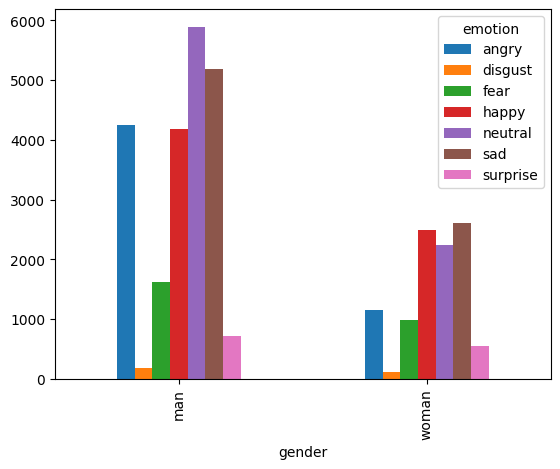

In [3]:
#Emotion Distribution by Gender
trail.groupby(['gender', 'emotion']).size().unstack().plot(kind='bar')

In [4]:
col_names = [
    'year', 'value 1', 'value 2', 'value 3'
]

In [5]:
def read_and_preprocess_csv(filename, prefix):
    df = pd.read_csv(filename, header=None)
    max_columns = df.apply(lambda row: len(row.dropna()), axis=1).max()
    column_names = ['Year'] + [f'{prefix} {i}' for i in range(1, max_columns)]
    df.columns = column_names
    # df = df.fillna('')
    return df

In [6]:
f_adj = read_and_preprocess_csv('female_adjectives.csv', 'Adj')
f_verb = read_and_preprocess_csv('female_verb.csv', 'Verb')
f_adjv = read_and_preprocess_csv('female_adjverb.csv','Adv')

In [7]:
f_cent = pd.read_csv('female_centrality.csv')
f_mcent = pd.read_csv('female_mentions_centrality.csv')

In [8]:
def remove_empty(df,col_name):
  cleaned_df = df.dropna(subset=[f'{col_name} 1'])
  return cleaned_df

In [9]:
f_adj = remove_empty(f_adj,'Adj')
f_verb = remove_empty(f_verb,'Verb')
f_adjv = remove_empty(f_adjv,'Adv')

In [10]:
trail.rename(columns = {'frame_number':'Frame Number',
                       'gender':'Gender',
                        'emotion':'Emotion',
                        'year':'Year',
                        'movie_name':'Movie Name'},
            inplace = True)
print(trail)

       Frame Number Gender   Emotion  Year    Movie Name
0                28  woman     happy  2014  dedh_ishqiya
1                62  woman     happy  2014  dedh_ishqiya
2                60    man     angry  2014  dedh_ishqiya
3                60    man       sad  2014  dedh_ishqiya
4                60    man     angry  2014  dedh_ishqiya
...             ...    ...       ...   ...           ...
32192            18    man     happy  2016   housefull_3
32193            25    man   neutral  2016   housefull_3
32194            25    man   neutral  2016   housefull_3
32195            25    man     happy  2016   housefull_3
32196            31    man  surprise  2016   housefull_3

[32197 rows x 5 columns]


In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import sentiwordnet as swn 
from textblob import TextBlob

In [12]:
def pos_tag_text(text):
    tokens = word_tokenize(text)
    return nltk.pos_tag(tokens)

In [13]:
def classify_token_sentiment(token):
    synsets = list(swn.senti_synsets(token))
    if synsets:
        pos_score = sum(s.pos_score() for s in synsets)/len(synsets)
        neg_score = sum(s.neg_score() for s in synsets) / len(synsets)
        return 'positive' if pos_score > neg_score else 'negative' if neg_score > pos_score else 'neutral'
    else:
        return 'neutral'

In [14]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return 'positive' if polarity > 0 else 'negative' if polarity < 0 else 'neutral'

In [15]:
def extract_features(df, category):
    feature_data = []
    
    for idx, row in df.iterrows():
        tokens = []
        for col in df.columns[1:]:
            value = row[col]
            if isinstance(value, str):
                tokens.extend(value.split(','))
        
        token_sentiments = [classify_token_sentiment(token) for token in tokens]
        token_freq = {sentiment: token_sentiments.count(sentiment) for sentiment in ['positive', 'negative', 'neutral']}
        
        token_diversity = len(set(tokens)) / len(tokens) if tokens else 0
        
        token_polarity = analyze_sentiment(' '.join(tokens))
        
        features_dict = {
            'Year': row['Year'],
            f'Positive_{category}_Freq': token_freq['positive'],
            f'Negative_{category}_Freq': token_freq['negative'],
            f'Neutral_{category}_Freq': token_freq['neutral'],
            f'{category}_Diversity': token_diversity,
            f'{category}_Polarity': token_polarity
        }
        
        feature_data.append(features_dict)

    feature_df = pd.DataFrame(feature_data)
    
    return feature_df

f_adj_features = extract_features(f_adj, 'Adj')

f_verb_features = extract_features(f_verb, 'Verb')

f_adjv_features = extract_features(f_adjv, 'Adjv')


In [16]:
print("Features extracted from f_adj:")
print(f_adj_features.head(10))

Features extracted from f_adj:
   Year  Positive_Adj_Freq  Negative_Adj_Freq  Neutral_Adj_Freq  \
0  1970                  0                  0                 1   
1  1970                  0                  1                 0   
2  1970                  0                  0                 1   
3  1970                  1                  0                 0   
4  1970                  0                  0                 1   
5  1970                  1                  0                 0   
6  1970                  1                  0                 0   
7  1970                  0                  1                 0   
8  1970                  1                  0                 0   
9  1970                  1                  0                 1   

   Adj_Diversity Adj_Polarity  
0            1.0     positive  
1            1.0      neutral  
2            1.0      neutral  
3            1.0     positive  
4            1.0     positive  
5            1.0     positive  
6      

In [25]:
print("\nFeatures extracted from f_verb:")
print(f_verb_features.head())


Features extracted from f_verb:
   Year  Positive_Verb_Freq  Negative_Verb_Freq  Neutral_Verb_Freq  \
0  1970                   0                   0                  1   
1  1970                   0                   0                  1   
2  1970                   1                   0                  0   
3  1970                   1                   0                  1   
4  1970                   1                   0                  1   

   Verb_Diversity Verb_Polarity  
0             1.0       neutral  
1             1.0       neutral  
2             1.0       neutral  
3             1.0       neutral  
4             1.0       neutral  


In [26]:
print("\nFeatures extracted from f_adjv:")
print(f_adjv_features.head())


Features extracted from f_adjv:
   Year  Positive_Adjv_Freq  Negative_Adjv_Freq  Neutral_Adjv_Freq  \
0  1970                   0                   0                  2   
1  1970                   0                   0                  1   
2  1970                   1                   0                  0   
3  1970                   1                   0                  1   
4  1970                   1                   1                  1   

   Adjv_Diversity Adjv_Polarity  
0             1.0      positive  
1             1.0       neutral  
2             1.0       neutral  
3             1.0       neutral  
4             1.0       neutral  


Summary Statistics:
              Year  Positive_Adj_Freq  Negative_Adj_Freq  Neutral_Adj_Freq  \
count  1237.000000        1237.000000        1237.000000       1237.000000   
mean   1997.261924           0.385610           0.323363          0.489895   
std      13.505397           0.486936           0.467949          0.690389   
min    1970.000000           0.000000           0.000000          0.000000   
25%    1986.000000           0.000000           0.000000          0.000000   
50%    2000.000000           0.000000           0.000000          0.000000   
75%    2009.000000           1.000000           1.000000          1.000000   
max    2017.000000           1.000000           1.000000          5.000000   

       Adj_Diversity  
count         1237.0  
mean             1.0  
std              0.0  
min              1.0  
25%              1.0  
50%              1.0  
75%              1.0  
max              1.0  


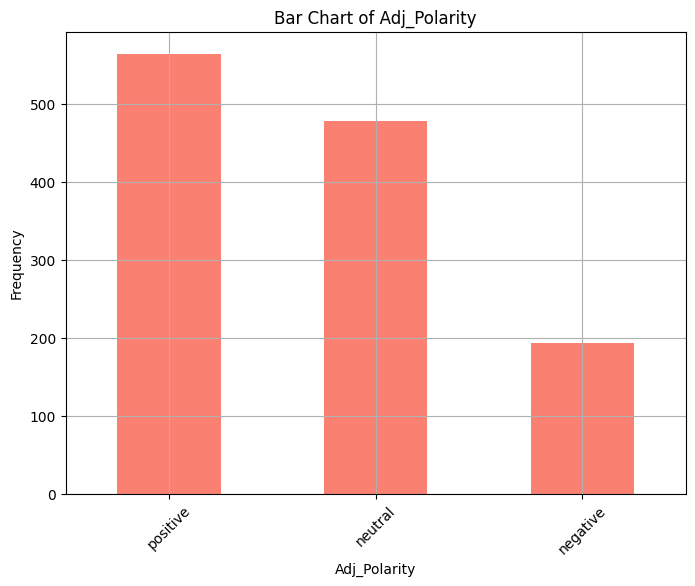

In [29]:
def perform_eda(df):
    # Summary Statistics
    summary_stats = df.describe()
    print("Summary Statistics:")
    print(summary_stats)

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        plt.figure(figsize=(8, 6))
        value_counts.plot(kind='bar', color='salmon')
        plt.title(f'Bar Chart of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()

perform_eda(f_adj_features)

Summary Statistics:
              Year  Positive_Verb_Freq  Negative_Verb_Freq  Neutral_Verb_Freq  \
count  3141.000000         3141.000000         3141.000000        3141.000000   
mean   1998.459089            0.587393            0.235594           1.565743   
std      13.064563            0.492382            0.424437           2.242445   
min    1970.000000            0.000000            0.000000           0.000000   
25%    1988.000000            0.000000            0.000000           0.000000   
50%    2002.000000            1.000000            0.000000           1.000000   
75%    2009.000000            1.000000            0.000000           2.000000   
max    2017.000000            1.000000            1.000000          21.000000   

       Verb_Diversity  
count          3141.0  
mean              1.0  
std               0.0  
min               1.0  
25%               1.0  
50%               1.0  
75%               1.0  
max               1.0  


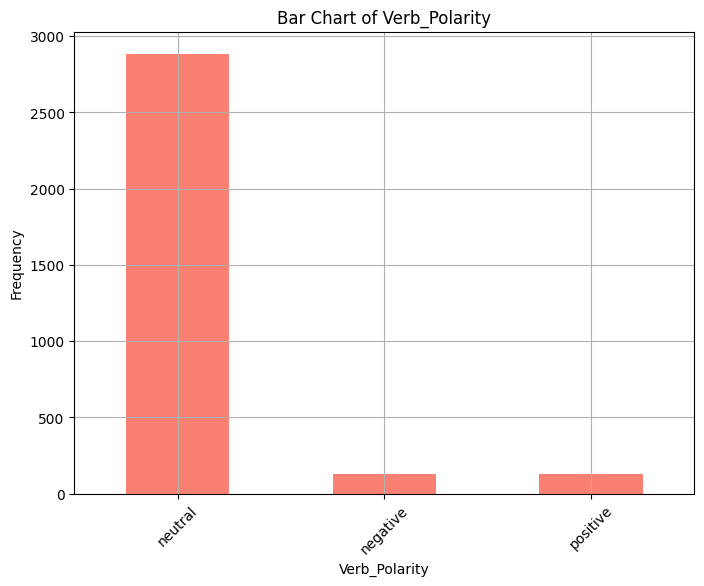

In [30]:
perform_eda(f_verb_features)

Summary Statistics:
              Year  Positive_Adjv_Freq  Negative_Adjv_Freq  Neutral_Adjv_Freq  \
count  1080.000000         1080.000000         1080.000000        1080.000000   
mean   1995.516667            0.641667            0.296296           1.354630   
std      13.390814            0.539733            0.486314           1.856576   
min    1970.000000            0.000000            0.000000           0.000000   
25%    1983.000000            0.000000            0.000000           0.000000   
50%    1998.000000            1.000000            0.000000           1.000000   
75%    2007.000000            1.000000            1.000000           2.000000   
max    2015.000000            2.000000            2.000000          11.000000   

       Adjv_Diversity  
count          1080.0  
mean              1.0  
std               0.0  
min               1.0  
25%               1.0  
50%               1.0  
75%               1.0  
max               1.0  


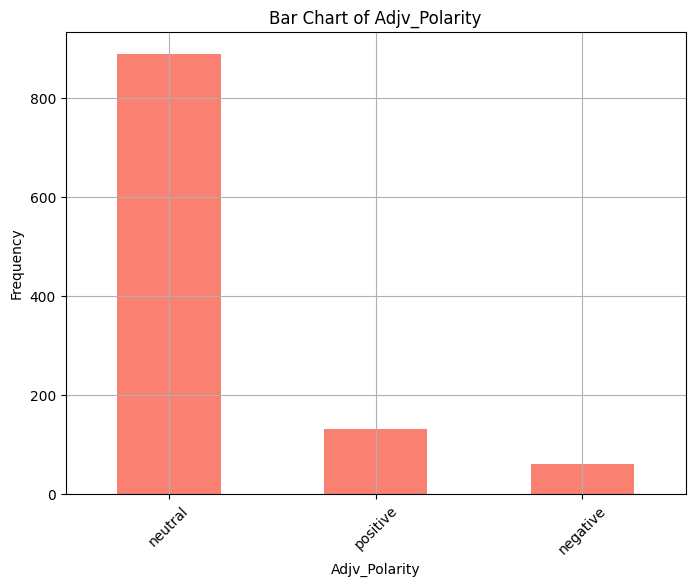

In [31]:
perform_eda(f_adjv_features)

In [20]:
coref_plot = pd.read_csv('coref_plot.csv')

print(coref_plot.info())
print(coref_plot.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34728 entries, 0 to 34727
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Movie Name  34728 non-null  object
 1   Coref Plot  34728 non-null  object
dtypes: object(2)
memory usage: 542.8+ KB
None
       Movie Name                                         Coref Plot
0  Aan Milo Sajna   Widowed and ailing Savitri Choudhury lives a ...
1  Aan Milo Sajna   Savitri knows that Anil is only waiting for S...
2  Aan Milo Sajna   The Diwan convinces Anil to mend Anil ways  g...
3  Aan Milo Sajna   Shortly thereafter Anil does appear to have m...
4  Aan Milo Sajna   Deepali moves in the mansion  looks after Sav...


In [21]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

coref_plot['Cleaned_Plot'] = coref_plot['Coref Plot'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

coref_plot['Tokenized_Plot'] = coref_plot['Cleaned_Plot'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
coref_plot['Tokenized_Plot'] = coref_plot['Tokenized_Plot'].apply(lambda x: [word for word in x if word not in stop_words])

lemmatizer = WordNetLemmatizer()
coref_plot['Lemmatized_Plot'] = coref_plot['Tokenized_Plot'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

coref_plot.to_csv('cleaned_coref_plot.csv', index=False)

In [22]:
cleaned_coref = pd.read_csv('cleaned_coref_plot.csv')
cleaned_coref

,Movie Name,Coref Plot,Cleaned_Plot,Tokenized_Plot,Lemmatized_Plot
0,Aan Milo Sajna,Widowed and ailing Savitri Choudhury lives a ...,widowed and ailing savitri choudhury lives a ...,"['widowed', 'ailing', 'savitri', 'choudhury', ...","['widowed', 'ailing', 'savitri', 'choudhury', ..."
1,Aan Milo Sajna,Savitri knows that Anil is only waiting for S...,savitri knows that anil is only waiting for s...,"['savitri', 'knows', 'anil', 'waiting', 'savit...","['savitri', 'know', 'anil', 'waiting', 'savitr..."
2,Aan Milo Sajna,The Diwan convinces Anil to mend Anil ways g...,the diwan convinces anil to mend anil ways g...,"['diwan', 'convinces', 'anil', 'mend', 'anil',...","['diwan', 'convinces', 'anil', 'mend', 'anil',..."
3,Aan Milo Sajna,Shortly thereafter Anil does appear to have m...,shortly thereafter anil does appear to have m...,"['shortly', 'thereafter', 'anil', 'appear', 'm...","['shortly', 'thereafter', 'anil', 'appear', 'm..."
4,Aan Milo Sajna,Deepali moves in the mansion looks after Sav...,deepali moves in the mansion looks after sav...,"['deepali', 'moves', 'mansion', 'looks', 'savi...","['deepali', 'move', 'mansion', 'look', 'savitr..."
...,...,...,...,...,...
34723,Jo Hum Chahein,Rohan discovers Amrita and Vikram were just u...,rohan discovers amrita and vikram were just u...,"['rohan', 'discovers', 'amrita', 'vikram', 'us...","['rohan', 'discovers', 'amrita', 'vikram', 'us..."
34724,Jo Hum Chahein,Rohan apologizes to Rohan father for all Roha...,rohan apologizes to rohan father for all roha...,"['rohan', 'apologizes', 'rohan', 'father', 'ro...","['rohan', 'apologizes', 'rohan', 'father', 'ro..."
34725,Jo Hum Chahein,Neha was n't ready for a child and was only h...,neha was nt ready for a child and was only ha...,"['neha', 'nt', 'ready', 'child', 'hurt', 'roha...","['neha', 'nt', 'ready', 'child', 'hurt', 'roha..."
34726,Jo Hum Chahein,Rohan is shattered Neha apologizes and asks ...,rohan is shattered neha apologizes and asks ...,"['rohan', 'shattered', 'neha', 'apologizes', '...","['rohan', 'shattered', 'neha', 'apologizes', '..."


In [23]:
from textblob import TextBlob

def analyze_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

coref_plot['Sentiment'] = coref_plot['Coref Plot'].apply(analyze_sentiment)

coref_plot


,Movie Name,Coref Plot,Cleaned_Plot,Tokenized_Plot,Lemmatized_Plot,Sentiment
0,Aan Milo Sajna,Widowed and ailing Savitri Choudhury lives a ...,widowed and ailing savitri choudhury lives a ...,"[widowed, ailing, savitri, choudhury, lives, w...","[widowed, ailing, savitri, choudhury, life, we...",positive
1,Aan Milo Sajna,Savitri knows that Anil is only waiting for S...,savitri knows that anil is only waiting for s...,"[savitri, knows, anil, waiting, savitri, die, ...","[savitri, know, anil, waiting, savitri, die, a...",neutral
2,Aan Milo Sajna,The Diwan convinces Anil to mend Anil ways g...,the diwan convinces anil to mend anil ways g...,"[diwan, convinces, anil, mend, anil, ways, get...","[diwan, convinces, anil, mend, anil, way, get,...",positive
3,Aan Milo Sajna,Shortly thereafter Anil does appear to have m...,shortly thereafter anil does appear to have m...,"[shortly, thereafter, anil, appear, mended, an...","[shortly, thereafter, anil, appear, mended, an...",positive
4,Aan Milo Sajna,Deepali moves in the mansion looks after Sav...,deepali moves in the mansion looks after sav...,"[deepali, moves, mansion, looks, savitri, much...","[deepali, move, mansion, look, savitri, much, ...",positive
...,...,...,...,...,...,...
34723,Jo Hum Chahein,Rohan discovers Amrita and Vikram were just u...,rohan discovers amrita and vikram were just u...,"[rohan, discovers, amrita, vikram, using, amri...","[rohan, discovers, amrita, vikram, using, amri...",negative
34724,Jo Hum Chahein,Rohan apologizes to Rohan father for all Roha...,rohan apologizes to rohan father for all roha...,"[rohan, apologizes, rohan, father, rohan, wron...","[rohan, apologizes, rohan, father, rohan, wron...",neutral
34725,Jo Hum Chahein,Neha was n't ready for a child and was only h...,neha was nt ready for a child and was only ha...,"[neha, nt, ready, child, hurt, rohan, keeping,...","[neha, nt, ready, child, hurt, rohan, keeping,...",positive
34726,Jo Hum Chahein,Rohan is shattered Neha apologizes and asks ...,rohan is shattered neha apologizes and asks ...,"[rohan, shattered, neha, apologizes, asks, roh...","[rohan, shattered, neha, apologizes, asks, roh...",neutral


In [33]:
f_adj['Merged_Column'] = f_adj.apply(lambda row: ','.join([str(row[col]) for col in row.index if col.startswith('Adj') and pd.notna(row[col])]), axis=1)

print(f_adj)

      Year           Adj 1 Adj 2 Adj 3 Adj 4 Adj 5 Adj 6   Merged_Column
0     1970           young   NaN   NaN   NaN   NaN   NaN           young
4     1970  unrecognizable   NaN   NaN   NaN   NaN   NaN  unrecognizable
9     1970          sister   NaN   NaN   NaN   NaN   NaN          sister
18    1970            real   NaN   NaN   NaN   NaN   NaN            real
21    1970           young   NaN   NaN   NaN   NaN   NaN           young
...    ...             ...   ...   ...   ...   ...   ...             ...
5035  2008         widowed   NaN   NaN   NaN   NaN   NaN         widowed
5044  2008          Indian   NaN   NaN   NaN   NaN   NaN          Indian
5045  2008           young   NaN   NaN   NaN   NaN   NaN           young
5056  1971            long   NaN   NaN   NaN   NaN   NaN            long
5057  1971       beautiful   NaN   NaN   NaN   NaN   NaN       beautiful

[1237 rows x 8 columns]


In [34]:
merged_column_name = 'Merged_Column'

# Create a new DataFrame with the merged column
merged_f_adj = pd.DataFrame(f_adj[merged_column_name])

# Display the new DataFrame
print(merged_f_adj)


       Merged_Column
0              young
4     unrecognizable
9             sister
18              real
21             young
...              ...
5035         widowed
5044          Indian
5045           young
5056            long
5057       beautiful

[1237 rows x 1 columns]


In [35]:
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

def filter_appearance_adjectives(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    stereo_adjectives = [token.lower() for token, tag in tagged_tokens if token.lower() in ['beautiful', 'pretty', 'rich', 'attractive', 'handsome','unmarried','dumb','uptight','goregous','wealthy','feisty','simple','vivacious']]
    return stereo_adjectives

merged_f_adj['Appearance_Adjectives'] = merged_f_adj['Merged_Column'].apply(filter_appearance_adjectives)

appearance_counts = merged_f_adj['Appearance_Adjectives'].explode().value_counts()

print("Occurrences of appearance-related adjectives:")
print(appearance_counts)


Occurrences of appearance-related adjectives:
Appearance_Adjectives
beautiful     90
rich          38
wealthy       23
attractive    12
simple        11
pretty         9
unmarried      8
feisty         6
vivacious      4
dumb           2
handsome       1
uptight        1
Name: count, dtype: int64


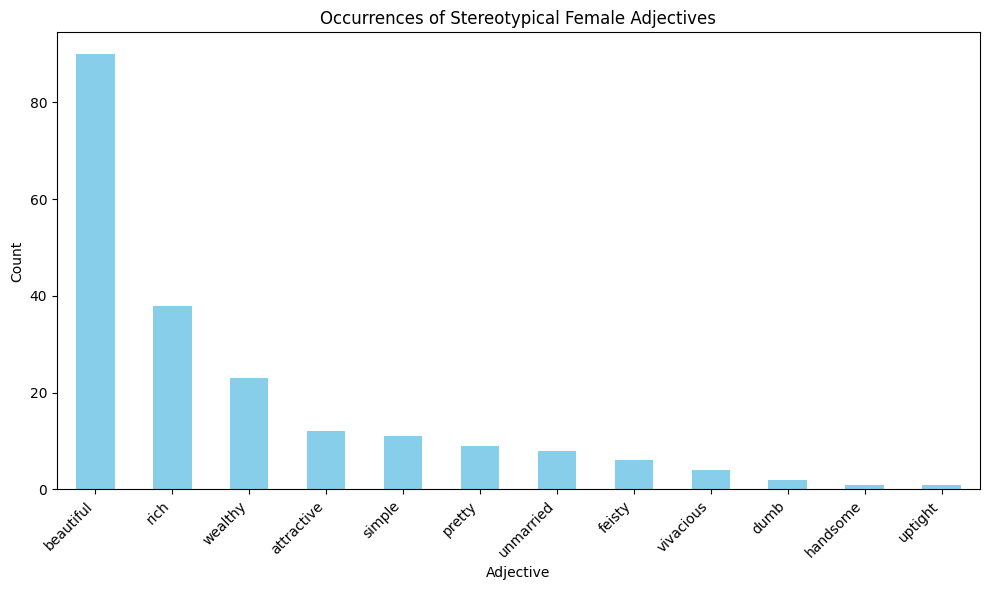

In [36]:
plt.figure(figsize=(10, 6))
appearance_counts.plot(kind='bar', color='skyblue')
plt.title('Occurrences of Stereotypical Female Adjectives')
plt.xlabel('Adjective')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
